Importando bibliotecas necessárias

In [79]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import geopandas as gpd
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import fitz




**Atribuindo Datasets**

In [80]:
df_bens = pd.read_csv("bem_candidato_2024_BRASIL.csv", encoding='latin1', delimiter=';')
df_cand1 = pd.read_csv("consulta_cand_2024_BRASIL.csv", encoding='latin1', delimiter=';')
df_cand2 = pd.read_csv("consulta_cand_complementar_2024_BRASIL.csv", encoding='latin1', delimiter=';')

**Pesquisando por colunas com dados únicos (não vão afetar as outras colunas)**

In [81]:
df_bens.nunique()

DT_GERACAO                         1
HH_GERACAO                         1
ANO_ELEICAO                        1
CD_TIPO_ELEICAO                    1
NM_TIPO_ELEICAO                    1
CD_ELEICAO                         1
DS_ELEICAO                         1
DT_ELEICAO                         1
SG_UF                             26
SG_UE                           5569
NM_UE                           5296
SQ_CANDIDATO                  295891
NR_ORDEM_BEM_CANDIDATO           351
CD_TIPO_BEM_CANDIDATO             50
DS_TIPO_BEM_CANDIDATO             50
DS_BEM_CANDIDATO              543999
VR_BEM_CANDIDATO              182590
DT_ULT_ATUAL_BEM_CANDIDATO        35
HH_ULT_ATUAL_BEM_CANDIDATO      9201
dtype: int64

In [82]:
df_cand1.nunique()

DT_GERACAO                            1
HH_GERACAO                            1
ANO_ELEICAO                           1
CD_TIPO_ELEICAO                       1
NM_TIPO_ELEICAO                       1
NR_TURNO                              2
CD_ELEICAO                            2
DS_ELEICAO                            1
DT_ELEICAO                            2
TP_ABRANGENCIA                        1
SG_UF                                26
SG_UE                              5569
NM_UE                              5296
CD_CARGO                              3
DS_CARGO                              3
SQ_CANDIDATO                     463394
NR_CANDIDATO                      15775
NM_CANDIDATO                     444309
NM_URNA_CANDIDATO                366052
NM_SOCIAL_CANDIDATO                 348
NR_CPF_CANDIDATO                      1
DS_EMAIL                              1
CD_SITUACAO_CANDIDATURA               1
DS_SITUACAO_CANDIDATURA               1
TP_AGREMIACAO                         3


In [83]:
df_cand2.nunique()

DT_GERACAO                            1
HH_GERACAO                            1
ANO_ELEICAO                           1
CD_ELEICAO                            2
SQ_CANDIDATO                     463394
CD_DETALHE_SITUACAO_CAND              1
DS_DETALHE_SITUACAO_CAND              1
CD_NACIONALIDADE                      5
DS_NACIONALIDADE                      5
CD_MUNICIPIO_NASCIMENTO               1
NM_MUNICIPIO_NASCIMENTO            5362
NR_IDADE_DATA_POSSE                  85
ST_QUILOMBOLA                         2
CD_ETNIA_INDIGENA                   176
DS_ETNIA_INDIGENA                   176
VR_DESPESA_MAX_CAMPANHA            3806
ST_REELEICAO                          3
ST_DECLARAR_BENS                      3
NR_PROTOCOLO_CANDIDATURA              1
NR_PROCESSO                      463394
CD_SITUACAO_CANDIDATO_PLEITO          1
DS_SITUACAO_CANDIDATO_PLEITO          1
CD_SITUACAO_CANDIDATO_URNA            1
DS_SITUACAO_CANDIDATO_URNA            1
ST_CANDIDATO_INSERIDO_URNA            2


**Apagando colunas com dados únicos**

In [84]:
df_bens = df_bens.drop(columns = ['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO', 'NM_TIPO_ELEICAO', 'CD_ELEICAO', 'DS_ELEICAO', 'DT_ELEICAO'])

In [85]:
df_cand1 = df_cand1.drop(columns = ['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO', 'CD_TIPO_ELEICAO', 'NM_TIPO_ELEICAO'])

In [86]:
df_cand2 = df_cand2.drop(columns = ['DT_GERACAO', 'HH_GERACAO', 'ANO_ELEICAO'])

**Relacionando os Datasets por Candidato**

In [87]:
df_merged = pd.merge(df_bens, df_cand1, on='SQ_CANDIDATO', how='inner')
df_merged = pd.merge(df_merged, df_cand2, on='SQ_CANDIDATO', how='inner')

In [88]:
def extrair_valor(bem):
    bem_str = str(bem) 
    bem_str = bem_str.replace(',', '.')  # Trocar vírgula por ponto (para decimais)
    
    valor = re.findall(r'[-+]?\d*\.\d+|\d+', bem_str)  # Isso vai capturar números com decimais e inteiros
    
    if valor:
        try:
            #Tenta converter pra float
            return float(valor[0])
        except ValueError:
            return 0  
    return 0  


In [89]:
df_merged['VALOR_BEM_NUM'] = df_merged['VR_BEM_CANDIDATO'].apply(extrair_valor)

df_soma_bens = df_merged.groupby('SQ_CANDIDATO')['VALOR_BEM_NUM'].sum().reset_index() #Soma os bens de cada cada candidato
df_soma_bens.columns = ['SQ_CANDIDATO', 'SOMA_BENS'] #Renomeia

df_quantidade_bens = df_merged.groupby('SQ_CANDIDATO')['VALOR_BEM_NUM'].count().reset_index()
df_quantidade_bens.columns = ['SQ_CANDIDATO', 'QUANTIDADE_BENS']

df_candidatos_bens = pd.merge(df_soma_bens, df_quantidade_bens, on='SQ_CANDIDATO')

df_candidatos_bens['MEDIA_BENS'] = df_candidatos_bens['SOMA_BENS'] / df_candidatos_bens['QUANTIDADE_BENS']



In [90]:
df_merged = pd.merge(df_merged, df_candidatos_bens[['SQ_CANDIDATO', 'SOMA_BENS', 'QUANTIDADE_BENS', 'MEDIA_BENS']], on='SQ_CANDIDATO', how='left')

**Primeira Conclusão**

In [91]:
df_eleitos = df_merged[df_merged['DS_SIT_TOT_TURNO'] == 'ELEITO']

media_valor_bens_eleitos = df_eleitos['SOMA_BENS'].mean()
media_quantidade_bens_eleitos = df_eleitos['QUANTIDADE_BENS'].mean() 

print(f"Média de valor de bens dos candidatos eleitos: {media_valor_bens_eleitos}")
print(f"Média de quantidade de bens dos candidatos eleitos: {media_quantidade_bens_eleitos}")

media_valor_bens_total = df_merged['SOMA_BENS'].mean()
media_quantidade_bens_total = df_merged['QUANTIDADE_BENS'].mean()

print(f"Média de valor de bens de todos os candidatos: {media_valor_bens_total}")
print(f"Média de quantidade de bens de todos os candidatos: {media_quantidade_bens_total}")

if media_valor_bens_eleitos > media_valor_bens_total:
    print("Os candidatos eleitos declararam um maior valor de bens.")
else:
    print("Os candidatos eleitos não declararam um maior valor de bens.")

if media_quantidade_bens_eleitos > media_quantidade_bens_total:
    print("Os candidatos eleitos declararam uma maior quantidade de bens.")
else:
    print("Os candidatos eleitos não declararam uma maior quantidade de bens.")

Média de valor de bens dos candidatos eleitos: 6275564.6591416355
Média de quantidade de bens dos candidatos eleitos: 18.62960445256405
Média de valor de bens de todos os candidatos: 2301190.153077432
Média de quantidade de bens de todos os candidatos: 8.437122437986686
Os candidatos eleitos declararam um maior valor de bens.
Os candidatos eleitos declararam uma maior quantidade de bens.


**Segunda conclusão**

In [92]:
df_coligacao = pd.read_csv("consulta_coligacao_2024_BRASIL.csv", encoding='latin1', delimiter=';')

In [93]:
df_coligacao['NUMERO_PARTIDOS'] = df_coligacao['DS_COMPOSICAO_FEDERACAO'].apply(lambda x: len(x.split('/')))

df_candidatos_coligacao = pd.merge(df_merged, df_coligacao[['SQ_COLIGACAO', 'NUMERO_PARTIDOS']], on='SQ_COLIGACAO', how='left')

df_eleitos = df_candidatos_coligacao[df_candidatos_coligacao['DS_SIT_TOT_TURNO'] == 'ELEITO']

df_eleitos_por_coligacao = df_eleitos.groupby('SQ_COLIGACAO').size().reset_index(name='NUMERO_ELEITOS')

df_resultado = pd.merge(df_coligacao[['SQ_COLIGACAO', 'NUMERO_PARTIDOS']], df_eleitos_por_coligacao, on='SQ_COLIGACAO', how='left')

print(df_resultado.corr())  # calculando a correlação entre número de partidos e número de eleitos


                 SQ_COLIGACAO  NUMERO_PARTIDOS  NUMERO_ELEITOS
SQ_COLIGACAO         1.000000        -0.037019        0.002577
NUMERO_PARTIDOS     -0.037019         1.000000       -0.008770
NUMERO_ELEITOS       0.002577        -0.008770        1.000000


In [94]:
df_merged.columns

Index(['SG_UF_x', 'SG_UE_x', 'NM_UE_x', 'SQ_CANDIDATO',
       'NR_ORDEM_BEM_CANDIDATO', 'CD_TIPO_BEM_CANDIDATO',
       'DS_TIPO_BEM_CANDIDATO', 'DS_BEM_CANDIDATO', 'VR_BEM_CANDIDATO',
       'DT_ULT_ATUAL_BEM_CANDIDATO', 'HH_ULT_ATUAL_BEM_CANDIDATO', 'NR_TURNO',
       'CD_ELEICAO_x', 'DS_ELEICAO', 'DT_ELEICAO', 'TP_ABRANGENCIA', 'SG_UF_y',
       'SG_UE_y', 'NM_UE_y', 'CD_CARGO', 'DS_CARGO', 'NR_CANDIDATO',
       'NM_CANDIDATO', 'NM_URNA_CANDIDATO', 'NM_SOCIAL_CANDIDATO',
       'NR_CPF_CANDIDATO', 'DS_EMAIL', 'CD_SITUACAO_CANDIDATURA',
       'DS_SITUACAO_CANDIDATURA', 'TP_AGREMIACAO', 'NR_PARTIDO', 'SG_PARTIDO',
       'NM_PARTIDO', 'NR_FEDERACAO', 'NM_FEDERACAO', 'SG_FEDERACAO',
       'DS_COMPOSICAO_FEDERACAO', 'SQ_COLIGACAO', 'NM_COLIGACAO',
       'DS_COMPOSICAO_COLIGACAO', 'SG_UF_NASCIMENTO', 'DT_NASCIMENTO',
       'NR_TITULO_ELEITORAL_CANDIDATO', 'CD_GENERO', 'DS_GENERO',
       'CD_GRAU_INSTRUCAO', 'DS_GRAU_INSTRUCAO', 'CD_ESTADO_CIVIL',
       'DS_ESTADO_CIVIL', 'CD_COR_

In [95]:
candidatos_por_partido_uf = df_merged.groupby(['SG_UF_y', 'SG_PARTIDO']).size().reset_index(name='QUANTIDADE_CANDIDATOS')

partido_mais_candidatos_uf = candidatos_por_partido_uf.loc[candidatos_por_partido_uf.groupby('SG_UF_y')['QUANTIDADE_CANDIDATOS'].idxmax()]

print(partido_mais_candidatos_uf)


    SG_UF_y    SG_PARTIDO  QUANTIDADE_CANDIDATOS
9        AC            PP                    400
24       AL           MDB                   1609
67       AM         UNIÃO                   1097
70       AP           MDB                    155
107      BA           PSD                   8254
134      CE           PSB                   3618
158      ES            PP                   1701
196      GO         UNIÃO                   6258
202      MA           MDB                   2313
243      MG           PSD                  14723
269      MS          PSDB                   2852
285      MT            PL                   4746
305      PA           MDB                   3911
347      PB  REPUBLICANOS                   2558
367      PE           PSB                   2126
399      PI            PT                   3734
423      PR           PSD                  11604
444      RJ            PL                   2927
465      RN           MDB                   2129
493      RO         

**Terceira e Quinta Conclusão**

     SG_PARTIDO  QUANTIDADE_UFS
0           MDB               6
1           PSD               5
2            PP               3
3  REPUBLICANOS               3
4            PL               3
5           PSB               2
6         UNIÃO               2
7          PSDB               1
8            PT               1


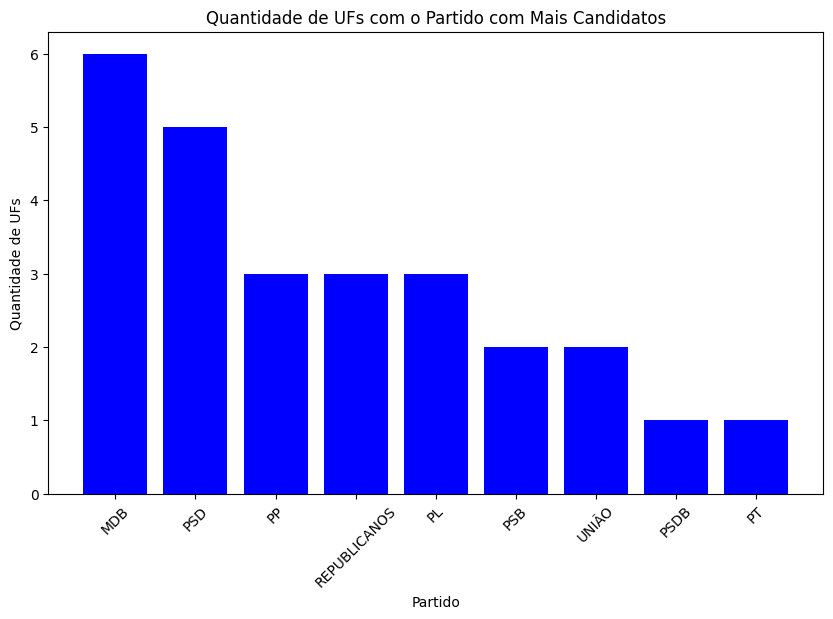

In [96]:
tendencia_partidos = partido_mais_candidatos_uf['SG_PARTIDO'].value_counts().reset_index()
tendencia_partidos.columns = ['SG_PARTIDO', 'QUANTIDADE_UFS']

print(tendencia_partidos)

plt.figure(figsize=(10, 6))
plt.bar(tendencia_partidos['SG_PARTIDO'], tendencia_partidos['QUANTIDADE_UFS'], color='blue')
plt.title('Quantidade de UFs com o Partido com Mais Candidatos')
plt.xlabel('Partido')
plt.ylabel('Quantidade de UFs')
plt.xticks(rotation=45)
plt.show()

**Quarta Conclusão**

          REGIAO    SG_PARTIDO  QUANTIDADE_UFS
0   Centro-Oeste            PL               1
1   Centro-Oeste          PSDB               1
2   Centro-Oeste         UNIÃO               1
3       Nordeste           MDB               3
4       Nordeste           PSB               2
5       Nordeste           PSD               2
6       Nordeste            PT               1
7       Nordeste  REPUBLICANOS               1
8          Norte           MDB               2
9          Norte            PL               1
10         Norte            PP               1
11         Norte  REPUBLICANOS               2
12         Norte         UNIÃO               1
13       Sudeste            PL               1
14       Sudeste            PP               1
15       Sudeste           PSD               2
16           Sul           MDB               1
17           Sul            PP               1
18           Sul           PSD               1


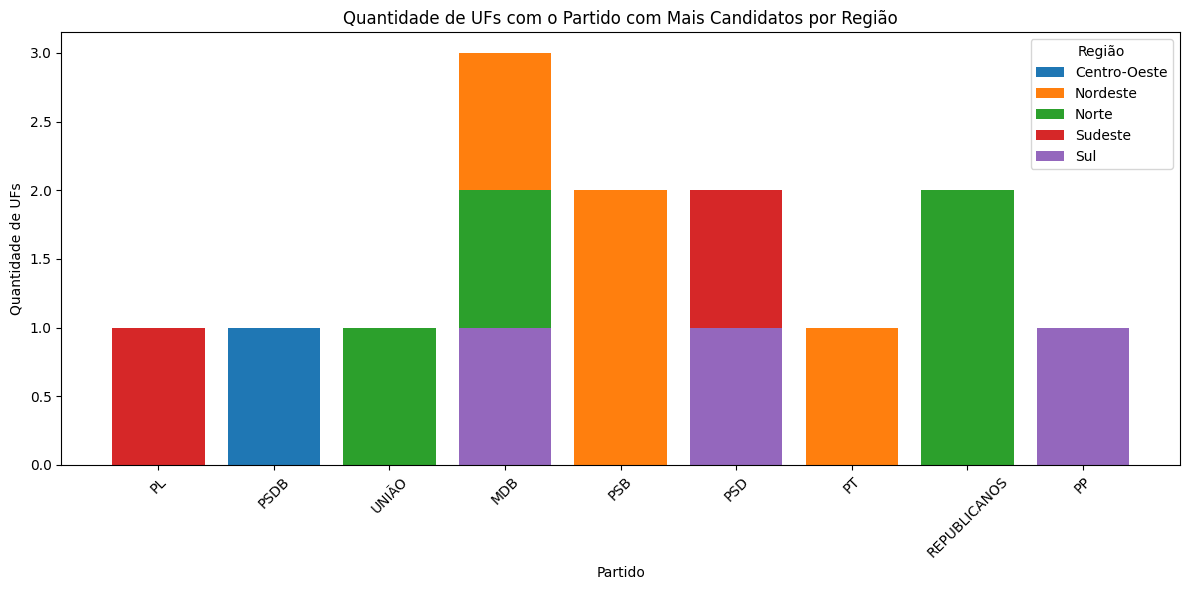

In [97]:
regiao_mapping = {
    'AC': 'Norte', 'AL': 'Nordeste', 'AP': 'Norte', 'AM': 'Norte',
    'BA': 'Nordeste', 'CE': 'Nordeste', 'DF': 'Centro-Oeste', 'ES': 'Sudeste',
    'GO': 'Centro-Oeste', 'MA': 'Nordeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste',
    'MG': 'Sudeste', 'PA': 'Norte', 'PB': 'Nordeste', 'PR': 'Sul',
    'PE': 'Nordeste', 'PI': 'Nordeste', 'RJ': 'Sudeste', 'RN': 'Nordeste',
    'RS': 'Sul', 'RO': 'Norte', 'RR': 'Norte', 'SC': 'Sul',
    'SE': 'Nordeste', 'SP': 'Sudeste', 'TO': 'Norte'
}

partido_mais_candidatos_uf['REGIAO'] = partido_mais_candidatos_uf['SG_UF_y'].map(regiao_mapping)

tendencia_partidos_regiao = partido_mais_candidatos_uf.groupby(['REGIAO', 'SG_PARTIDO']).size().reset_index(name='QUANTIDADE_UFS')

print(tendencia_partidos_regiao)

plt.figure(figsize=(12, 6))
for regiao in tendencia_partidos_regiao['REGIAO'].unique():
    subset = tendencia_partidos_regiao[tendencia_partidos_regiao['REGIAO'] == regiao]
    plt.bar(subset['SG_PARTIDO'], subset['QUANTIDADE_UFS'], label=regiao)

plt.title('Quantidade de UFs com o Partido com Mais Candidatos por Região')
plt.xlabel('Partido')
plt.ylabel('Quantidade de UFs')
plt.xticks(rotation=45)
plt.legend(title='Região')
plt.tight_layout()
plt.show()

**Sexta Conclusão**

In [98]:
df_merged["CD_ETNIA_INDIGENA"]

0         0
1         0
2         0
3        -1
4        -1
         ..
915242    0
915243    0
915244    0
915245    0
915246    0
Name: CD_ETNIA_INDIGENA, Length: 915247, dtype: int64

         REGIAO  QUANTIDADE_CANDIDATOS
0  Centro-Oeste                    852
1      Nordeste                   1936
2         Norte                   1040
3       Sudeste                   1763
4           Sul                    860


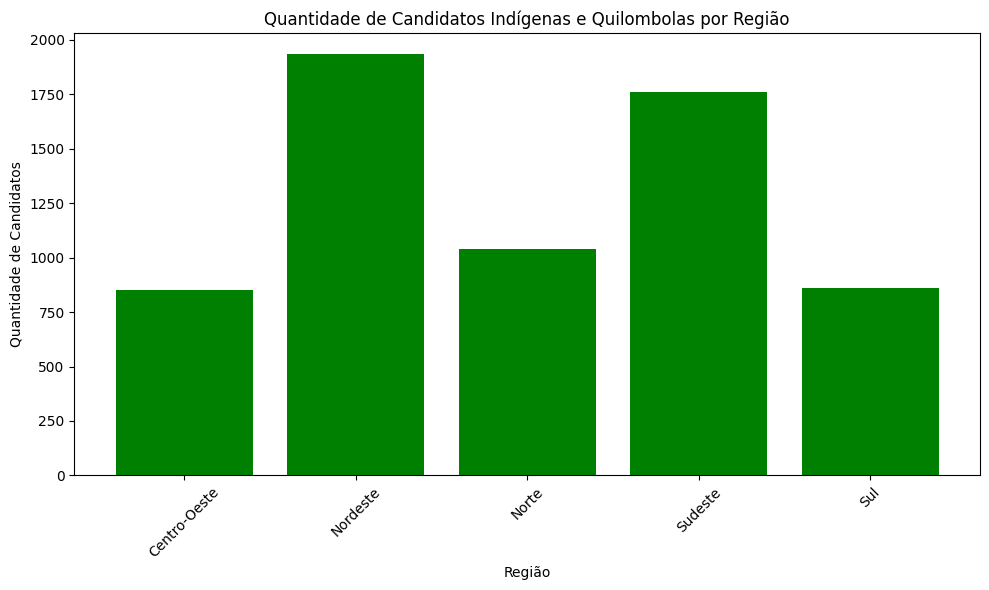

In [99]:
candidatos_indigenas = df_merged[df_merged['CD_ETNIA_INDIGENA'] > 0]

candidatos_quilombolas = df_merged[df_merged['ST_QUILOMBOLA'] == "S"]

candidatos_regiao = pd.concat([candidatos_indigenas, candidatos_quilombolas])

candidatos_regiao['REGIAO'] = candidatos_regiao['SG_UF_y'].map(regiao_mapping)

candidatos_por_regiao = candidatos_regiao.groupby('REGIAO').size().reset_index(name='QUANTIDADE_CANDIDATOS')

print(candidatos_por_regiao)

plt.figure(figsize=(10, 6))
plt.bar(candidatos_por_regiao['REGIAO'], candidatos_por_regiao['QUANTIDADE_CANDIDATOS'], color='green')
plt.title('Quantidade de Candidatos Indígenas e Quilombolas por Região')
plt.xlabel('Região')
plt.ylabel('Quantidade de Candidatos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [100]:
df_merged.columns

Index(['SG_UF_x', 'SG_UE_x', 'NM_UE_x', 'SQ_CANDIDATO',
       'NR_ORDEM_BEM_CANDIDATO', 'CD_TIPO_BEM_CANDIDATO',
       'DS_TIPO_BEM_CANDIDATO', 'DS_BEM_CANDIDATO', 'VR_BEM_CANDIDATO',
       'DT_ULT_ATUAL_BEM_CANDIDATO', 'HH_ULT_ATUAL_BEM_CANDIDATO', 'NR_TURNO',
       'CD_ELEICAO_x', 'DS_ELEICAO', 'DT_ELEICAO', 'TP_ABRANGENCIA', 'SG_UF_y',
       'SG_UE_y', 'NM_UE_y', 'CD_CARGO', 'DS_CARGO', 'NR_CANDIDATO',
       'NM_CANDIDATO', 'NM_URNA_CANDIDATO', 'NM_SOCIAL_CANDIDATO',
       'NR_CPF_CANDIDATO', 'DS_EMAIL', 'CD_SITUACAO_CANDIDATURA',
       'DS_SITUACAO_CANDIDATURA', 'TP_AGREMIACAO', 'NR_PARTIDO', 'SG_PARTIDO',
       'NM_PARTIDO', 'NR_FEDERACAO', 'NM_FEDERACAO', 'SG_FEDERACAO',
       'DS_COMPOSICAO_FEDERACAO', 'SQ_COLIGACAO', 'NM_COLIGACAO',
       'DS_COMPOSICAO_COLIGACAO', 'SG_UF_NASCIMENTO', 'DT_NASCIMENTO',
       'NR_TITULO_ELEITORAL_CANDIDATO', 'CD_GENERO', 'DS_GENERO',
       'CD_GRAU_INSTRUCAO', 'DS_GRAU_INSTRUCAO', 'CD_ESTADO_CIVIL',
       'DS_ESTADO_CIVIL', 'CD_COR_

**Sétima Conclusão**

In [101]:
partido_colors = {
    # Esquerda (vermelho)
    'PT': '#E03C31',             # Vermelho intenso
    'PC do B': '#C3272B',        # Vermelho escuro
    'PSTU': '#FF6347',           # Tomate
    'PSOL': '#FF4500',           # Laranja avermelhado
    'PCB': '#B22222',            # Vermelho queimado

    # Centro-esquerda (tons entre vermelho e azul)
    'REDE': '#FF7F50',           # Coral
    'PSB': '#FFA07A',            # Salmão
    'PDT': '#FF4500',            # Laranja mais vivo
    'CIDADANIA': '#FFA500',      # Laranja claro

    # Centro (tons de azul)
    'PSDB': '#4682B4',           # Azul aço
    'PPS': '#6495ED',            # Azul centáurea
    'MDB': '#4169E1',            # Azul royal
    'UNIÃO': '#1E90FF',          # Azul dodger
    'PODE': '#5F9EA0',           # Azul cadete
    'DEM': '#87CEEB',            # Azul claro

    # Centro-direita (tons azul-esverdeado)
    'PROS': '#20B2AA',           # Verde claro
    'PP': '#32CD32',             # Verde lima
    'PSD': '#3CB371',            # Verde mar
    'SOLIDARIEDADE': '#00FA9A',  # Verde esmeralda

    # Direita (verde)
    'PL': '#006400',             # Verde escuro
    'REPUBLICANOS': '#228B22',   # Verde floresta
    'PRB': '#8FBC8F',            # Verde escuro
    'PRTB': '#2E8B57',           # Verde mar escuro
    'PMB': '#66CDAA',            # Verde água-marinha
    'AGIR': '#7FFF00',           # Verde chartreuse
    'AVANTE': '#98FB98',         # Verde claro

    # Outros (mantenho mais neutros)
    'NOVO': '#FF8C00',           # Laranja escuro
    'DC': '#A9A9A9',             # Cinza escuro
    'PV': '#556B2F',             # Verde oliva
    'MOBILIZA': '#FFD700',       # Dourado
    'UP': '#FF1493'              # Rosa forte (neutro)
}

   NOME_REDE  QUANTIDADE_CANDIDATOS
0   facebook                  79023
1  instagram                 120589
2   linkedin                     57
3     tiktok                   1352
4    twitter                     10
5   whatsapp                     12
6    youtube                    204


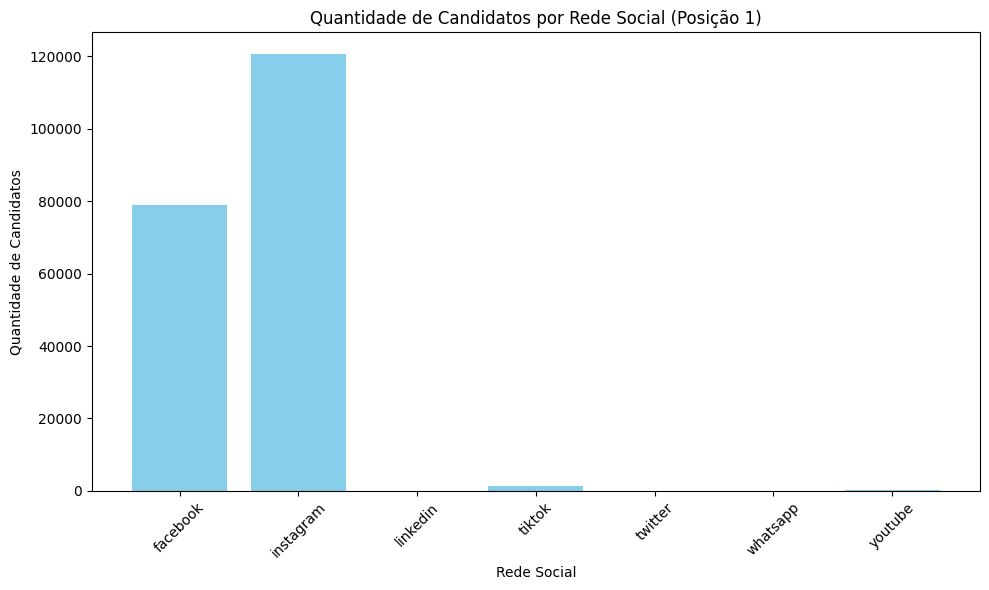

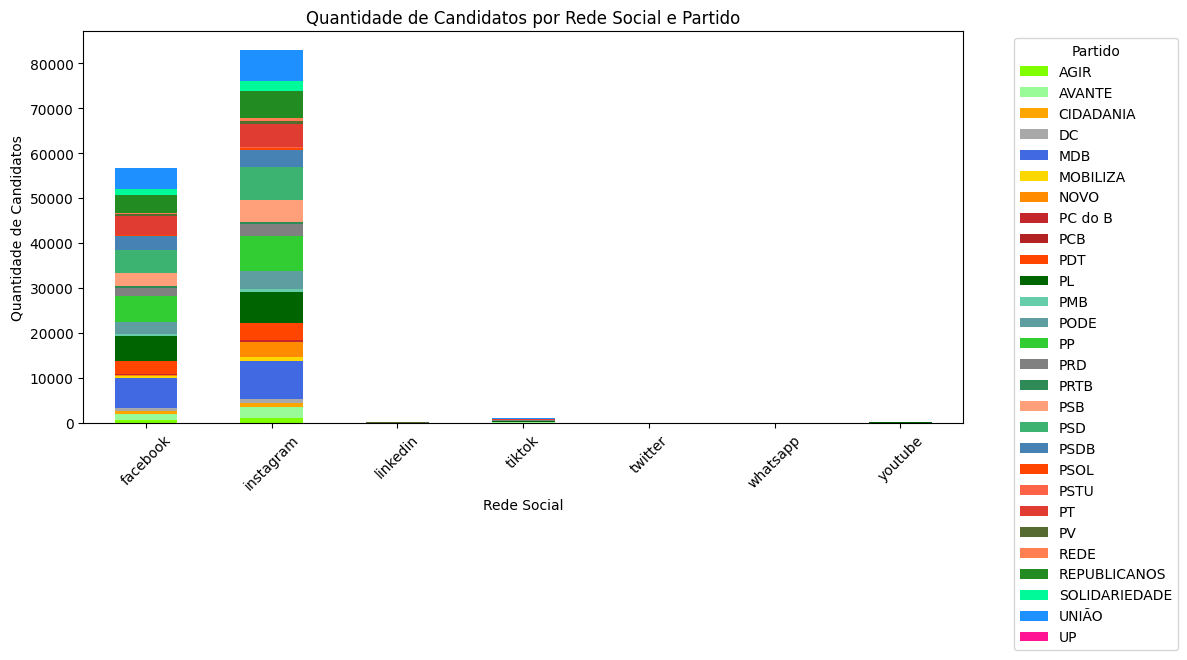

In [102]:
rede_social_df = pd.read_csv('rede_social_candidato_2024_BRASIL.csv', encoding='latin1', delimiter=';') 

def extrair_rede_social(url):
    match = re.search(r'www\.(.*?)\.com', url)
    return match.group(1) if match else None

rede_social_df['NOME_REDE'] = rede_social_df['DS_URL'].apply(extrair_rede_social)

rede_social_numero_1 = rede_social_df[rede_social_df['NR_ORDEM_REDE_SOCIAL'] == 1]

lista_redes_sociais = [
    'facebook',
    'twitter',
    'instagram',
    'linkedin',
    'tiktok',
    'youtube',
    'whatsapp',
    'snapchat',
    'twitch'
]

rede_social_numero_1_filter = rede_social_numero_1[rede_social_numero_1['NOME_REDE'].isin(lista_redes_sociais)]

dataset_rede_social_cand = rede_social_numero_1_filter[['SQ_CANDIDATO', 'NOME_REDE']]

contagem_rede_social = dataset_rede_social_cand.groupby('NOME_REDE')['SQ_CANDIDATO'].nunique().reset_index(name='QUANTIDADE_CANDIDATOS')

print(contagem_rede_social)

plt.figure(figsize=(10, 6))
plt.bar(contagem_rede_social['NOME_REDE'], contagem_rede_social['QUANTIDADE_CANDIDATOS'], color='skyblue')
plt.title('Quantidade de Candidatos por Rede Social (Posição 1)')
plt.xlabel('Rede Social')
plt.ylabel('Quantidade de Candidatos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

rede_social_numero_1_filtrada = rede_social_numero_1[rede_social_numero_1['NOME_REDE'].isin(lista_redes_sociais)]

merged_df = pd.merge(rede_social_numero_1_filtrada, df_merged[['SQ_CANDIDATO', 'SG_PARTIDO', 'SG_UF_y']], on='SQ_CANDIDATO', how='left')

dataset_rede_social_numero_1 = merged_df[['SQ_CANDIDATO', 'NOME_REDE', 'SG_PARTIDO', 'SG_UF_y']]

contagem_rede_social = dataset_rede_social_numero_1.groupby(['NOME_REDE', 'SG_PARTIDO']).agg({'SQ_CANDIDATO': 'nunique'}).reset_index()
contagem_rede_social.columns = ['Rede Social', 'Partido', 'Quantidade de Candidatos']

pivot_rede_social = contagem_rede_social.pivot(index='Rede Social', columns='Partido', values='Quantidade de Candidatos').fillna(0)


colors = [partido_colors.get(partido, '#808080') for partido in pivot_rede_social.columns]  # '#808080' é cinza para partidos sem cor definida

pivot_rede_social.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)
plt.title('Quantidade de Candidatos por Rede Social e Partido')
plt.xlabel('Rede Social')
plt.ylabel('Quantidade de Candidatos')
plt.xticks(rotation=45)
plt.legend(title='Partido', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Nona Conclusão**

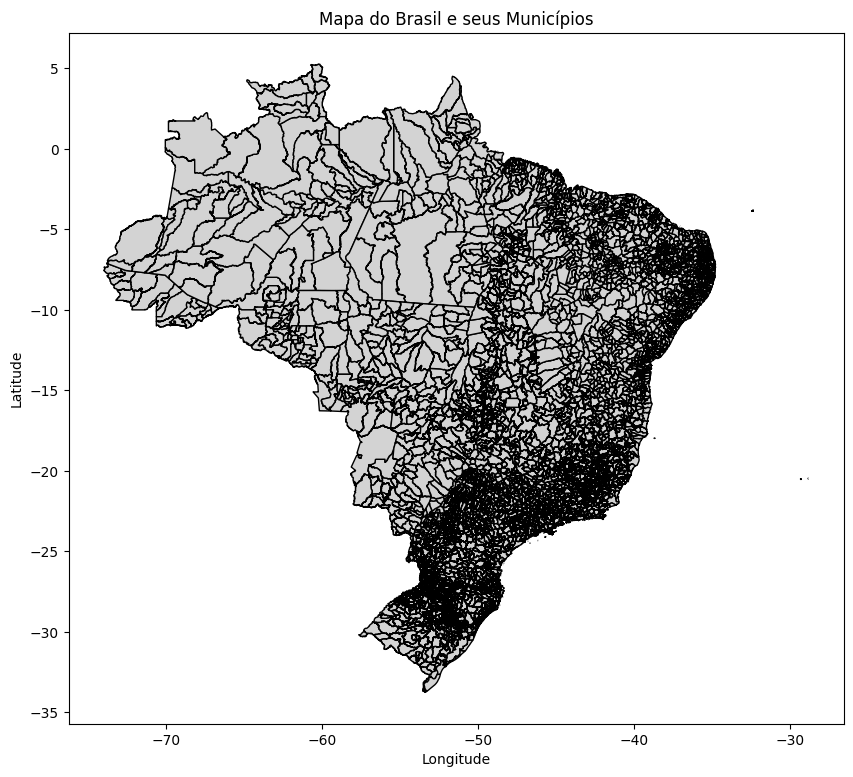

In [103]:
shapefile_path = 'BR_Municipios_2022'
mapa_brasil = gpd.read_file(shapefile_path)

fig, ax = plt.subplots(figsize=(10, 10))
mapa_brasil.plot(ax=ax, color='lightgray', edgecolor='black')
plt.title('Mapa do Brasil e seus Municípios')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [104]:
mapa_brasil.columns

Index(['CD_MUN', 'NM_MUN', 'SIGLA_UF', 'AREA_KM2', 'geometry'], dtype='object')

In [105]:
eleitos = df_cand1[df_cand1['DS_SIT_TOT_TURNO'] == 'ELEITO']

df_cidades_partidos = eleitos[['NM_UE', 'SG_PARTIDO']].drop_duplicates()

df_cidades_partidos.describe


<bound method NDFrame.describe of                           NM_UE    SG_PARTIDO
95                   SEROPÉDICA           MDB
107     SÃO GONÇALO DO GURGUÉIA            PT
109                    MUCURICI           PSB
115           SALTO DE PIRAPORA           PSD
540               URBANO SANTOS           MDB
...                         ...           ...
463107                IGARAPAVA  REPUBLICANOS
463165                 MONTADAS            PP
463326            CARMO DA MATA          PSDB
463502                  PARAÍSO            PL
463511               DESCOBERTO           PDT

[9620 rows x 2 columns]>

In [106]:
mapa_brasil['NM_MUN'] = mapa_brasil['NM_MUN'].str.upper()

mapa_brasil = mapa_brasil.merge(df_cidades_partidos, left_on='NM_MUN', right_on='NM_UE', how='left')

In [107]:
cor_padrao = 'lightgrey'

mapa_brasil['COR'] = mapa_brasil['SG_PARTIDO'].map(partido_colors).fillna(cor_padrao)

In [108]:
mapa_brasil.columns

Index(['CD_MUN', 'NM_MUN', 'SIGLA_UF', 'AREA_KM2', 'geometry', 'NM_UE',
       'SG_PARTIDO', 'COR'],
      dtype='object')

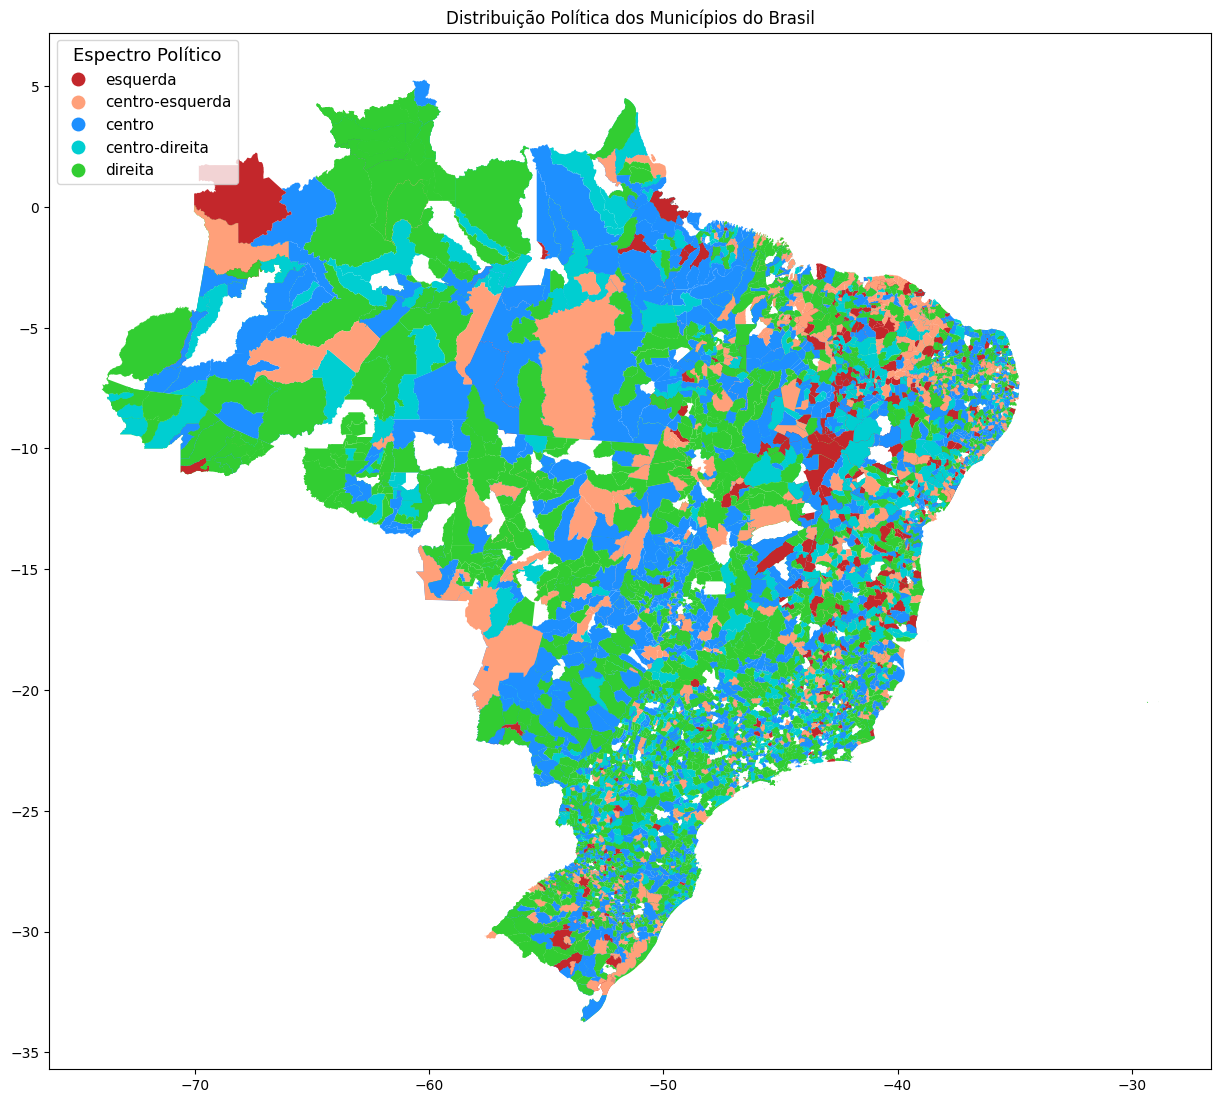

In [109]:
espectro_politico = {
    'PT': 'esquerda', 'PCdoB': 'esquerda', 'PSOL': 'esquerda', 'PSTU': 'esquerda', 'UP': 'esquerda',
    'PSB': 'centro-esquerda', 'PDT': 'centro-esquerda', 'CIDADANIA': 'centro-esquerda', 'PV': 'centro-esquerda',
    'PSDB': 'centro', 'MDB': 'centro', 'DEM': 'centro', 'REDE': 'centro', 'PODE': 'centro', 'PMB': 'centro',
    'PROS': 'centro-direita', 'PSD': 'centro-direita', 'SOLIDARIEDADE': 'centro-direita', 'DC': 'centro-direita',
    'PP': 'direita', 'PL': 'direita', 'REPUBLICANOS': 'direita', 'PRB': 'direita', 'PRTB': 'direita', 'PSC': 'direita',
    'AGIR': 'direita', 'AVANTE': 'direita', 'NOVO': 'direita', 'MOBILIZA': 'direita'
}

mapa_brasil['espectro_politico'] = mapa_brasil['SG_PARTIDO'].map(espectro_politico)

espectro_colors = {
    'esquerda': '#C3272B',        # Vermelho
    'centro-esquerda': '#FFA07A', # Laranja salmão
    'centro': '#1E90FF',          # Azul
    'centro-direita': '#00CED1',  # Turquesa
    'direita': '#32CD32'          # Verde lima
}

espectro_order = ['esquerda', 'centro-esquerda', 'centro', 'centro-direita', 'direita']
mapa_brasil['espectro_politico'] = pd.Categorical(mapa_brasil['espectro_politico'], categories=espectro_order, ordered=True)

cmap = ListedColormap([espectro_colors[espectro] for espectro in espectro_order])

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
mapa_brasil.plot(column='espectro_politico', cmap=cmap, legend=True, ax=ax,
                 legend_kwds={'loc': 'upper left', 'title': 'Espectro Político', 'title_fontsize': '13', 'fontsize': '11'})

ax.set_title('Distribuição Política dos Municípios do Brasil')
plt.show()


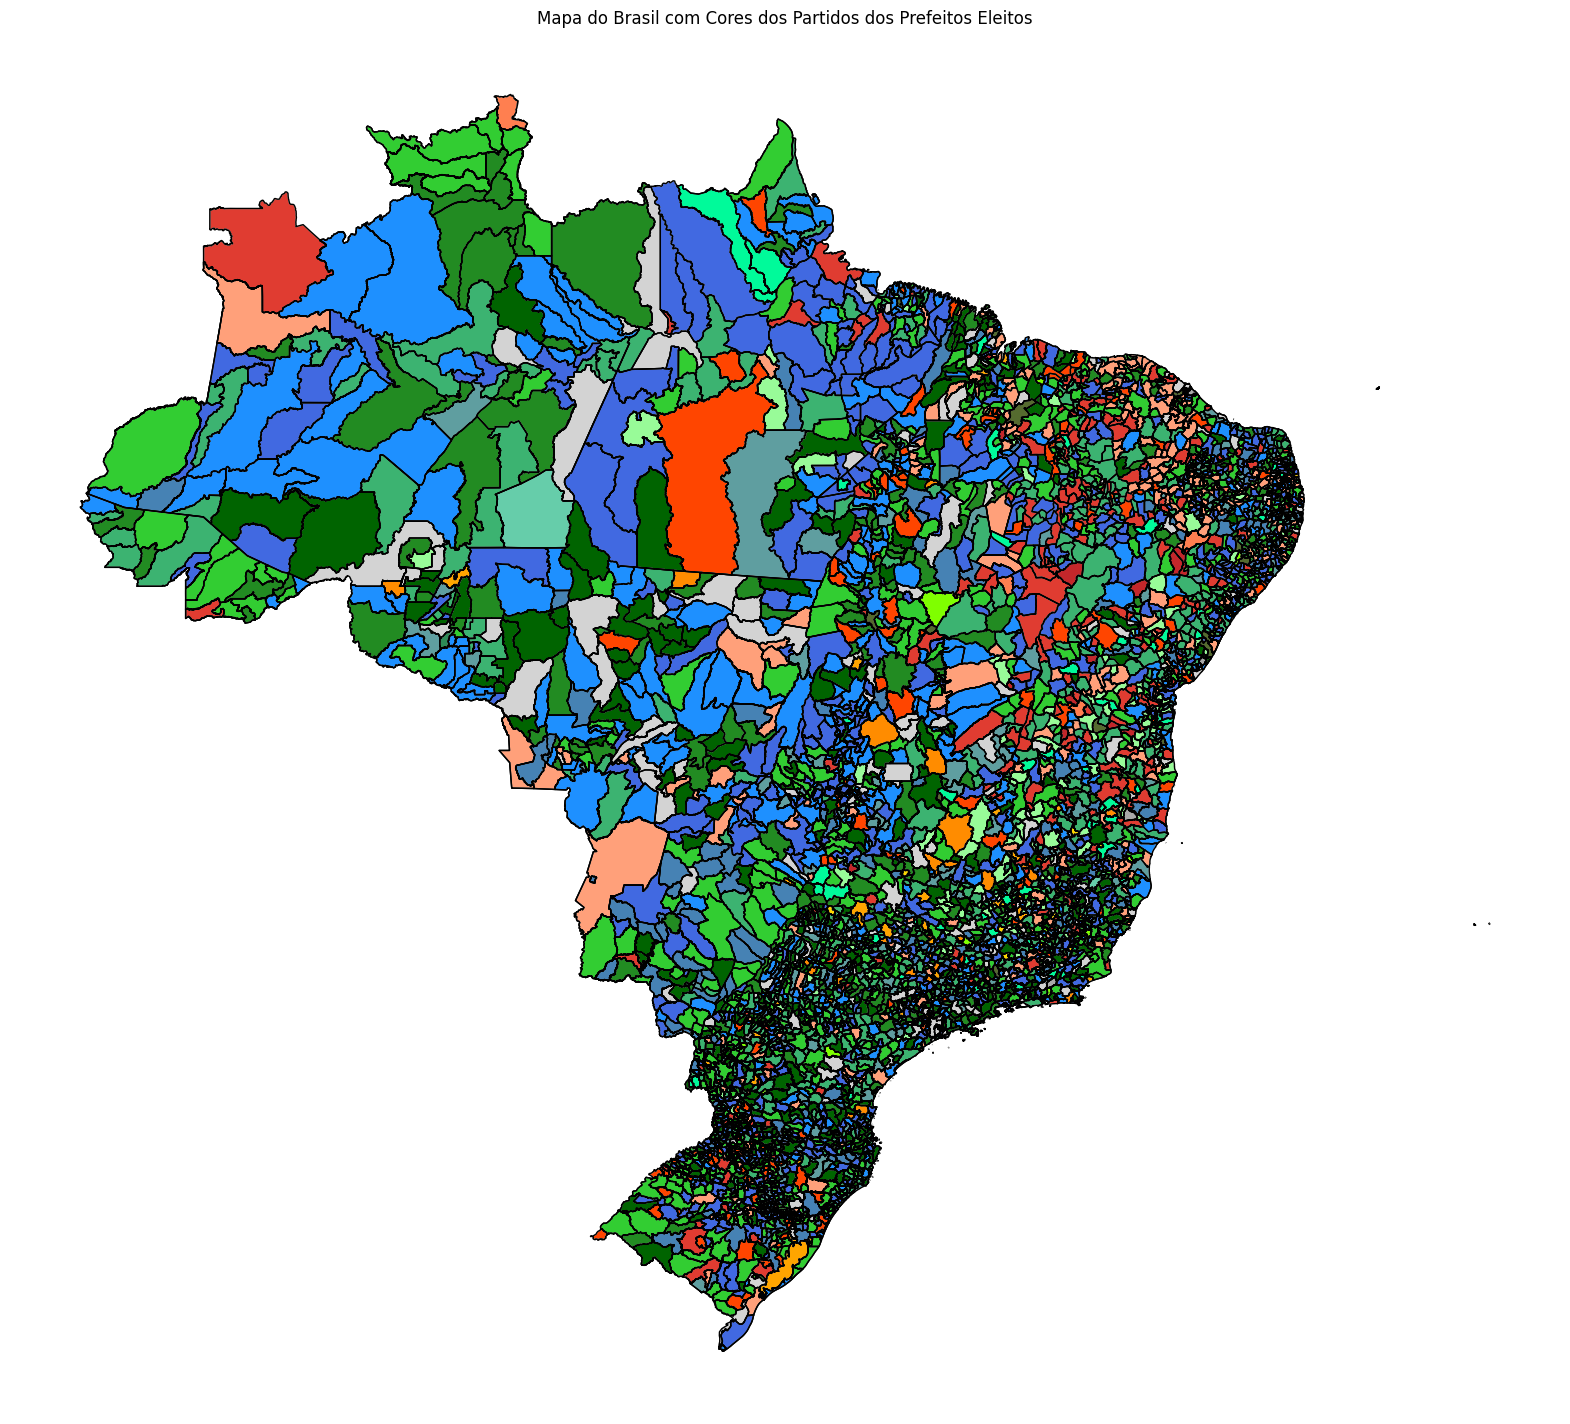

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
mapa_brasil.boundary.plot(ax=ax, linewidth=1, color='black')  # Plota as fronteiras
mapa_brasil.plot(ax=ax, color=mapa_brasil['COR'], edgecolor=cor_padrao)  # Plota o preenchimento com as cores

plt.title('Mapa do Brasil com Cores dos Partidos dos Prefeitos Eleitos')
plt.axis('off') 
plt.show()

In [111]:
mapa_brasil.head

<bound method NDFrame.head of         CD_MUN                 NM_MUN SIGLA_UF  AREA_KM2  \
0      1100015  ALTA FLORESTA D'OESTE       RO  7067.127   
1      1100015  ALTA FLORESTA D'OESTE       RO  7067.127   
2      1100023              ARIQUEMES       RO  4426.571   
3      1100023              ARIQUEMES       RO  4426.571   
4      1100031                 CABIXI       RO  1314.352   
...        ...                    ...      ...       ...   
10693  5222203               VILA BOA       GO  1052.593   
10694  5222203               VILA BOA       GO  1052.593   
10695  5222302          VILA PROPÍCIO       GO  2181.593   
10696  5222302          VILA PROPÍCIO       GO  2181.593   
10697  5300108               BRASÍLIA       DF  5760.784   

                                                geometry  \
0      POLYGON ((-62.00806 -12.13379, -62.00784 -12.2...   
1      POLYGON ((-62.00806 -12.13379, -62.00784 -12.2...   
2      POLYGON ((-63.17933 -10.13924, -63.17746 -10.1...   
3      PO

Oitava Conclusão

Frequências das palavras: [('', 362646), ('saúde', 11282), ('município', 10419), ('municipal', 10177), ('programa', 8260), ('educação', 7605), ('atendimento', 7011), ('desenvolvimento', 6590), ('ampliar', 6522), ('social', 6088), ('cidade', 6053), ('plano', 5912), ('promover', 5692), ('ações', 5663), ('criar', 5564), ('serviços', 5482), ('governo', 5293), ('gestão', 5140), ('população', 5054), ('programas', 5051)]


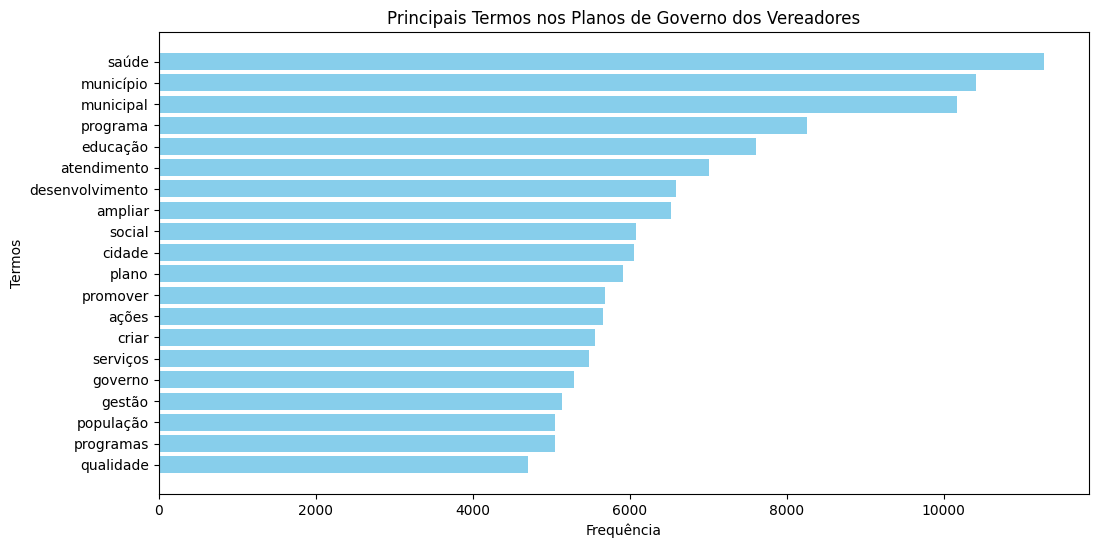

In [112]:
pasta_sc = 'SC'  

todas_as_palavras = []

stop_words = set(stopwords.words('portuguese'))


def extrair_texto_pdf(caminho_pdf):
    texto = ""
    with fitz.open(caminho_pdf) as pdf:
        for pagina in pdf:
            texto += pagina.get_text()
    return texto


for filename in os.listdir(pasta_sc):
    if filename.endswith('.pdf'):
        arquivo_pdf = os.path.join(pasta_sc, filename)
        texto = extrair_texto_pdf(arquivo_pdf)  
     
        palavras = word_tokenize(texto, language='portuguese')
        
        palavras_filtradas = [
            re.sub(r'[^\w\s]', '', palavra).lower() for palavra in palavras if palavra.lower() not in stop_words
        ]
        
        todas_as_palavras.extend(palavras_filtradas)


frequencias = Counter(todas_as_palavras)
print(f"Frequências das palavras: {frequencias.most_common(20)}")

frequencias_filtradas = {termo: freq for termo, freq in frequencias.items() if termo.strip()}


df_frequencias = pd.DataFrame(frequencias_filtradas.items(), columns=['Termo', 'Frequência'])

df_frequencias = df_frequencias.sort_values(by='Frequência', ascending=False)


top_n = 20  
plt.figure(figsize=(12, 6))
plt.barh(df_frequencias['Termo'][:top_n], df_frequencias['Frequência'][:top_n], color='skyblue')
plt.xlabel('Frequência')
plt.ylabel('Termos')
plt.title('Principais Termos nos Planos de Governo dos Vereadores')
plt.gca().invert_yaxis()  


            Termo  Frequência
0           saúde       11282
1        educação        7605
2      transporte        2776
3  infraestrutura        3092
4       segurança        4285
5         família        1191


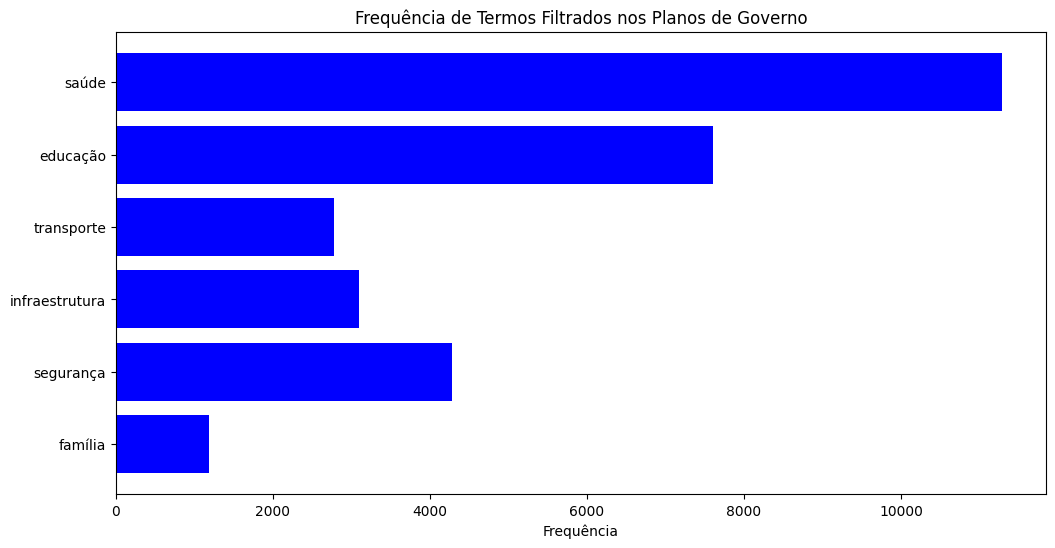

In [113]:
lista_palavras = ['saúde', 'educação', 'transporte', 'infraestrutura', 'segurança', 'família']  # Adicione mais palavras conforme necessário

frequencias_filtradas = {termo: freq for termo, freq in frequencias.items() if termo in lista_palavras}

df_frequencias_filtradas = pd.DataFrame(frequencias_filtradas.items(), columns=['Termo', 'Frequência'])

print(df_frequencias_filtradas)

plt.figure(figsize=(12, 6))
plt.barh(df_frequencias_filtradas['Termo'], df_frequencias_filtradas['Frequência'], color='blue')
plt.xlabel('Frequência')
plt.title('Frequência de Termos Filtrados nos Planos de Governo')
plt.gca().invert_yaxis() 
